In [1]:
import glob
import os

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from skimage.io import imread
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
# Setting the model parameters

img_size = 352
dataset_type = 'kvasir' # Options: kvasir/cvc-clinicdb/cvc-colondb/etis-laribpolypdb
learning_rate = 1e-4
seed_value = 58800

folder_path = "C:/jason/new magang/DUCK-Net/kvasir"  # Add the path to your data directory


In [3]:
images_path = []

list_files = os.listdir(os.path.join(folder_path, 'images'))
list_files = [os.path.join(folder_path, 'images', file) for file in list_files]
images_path+=list_files

masks_path = list(map(lambda x: x.replace('images', 'masks'), images_path))

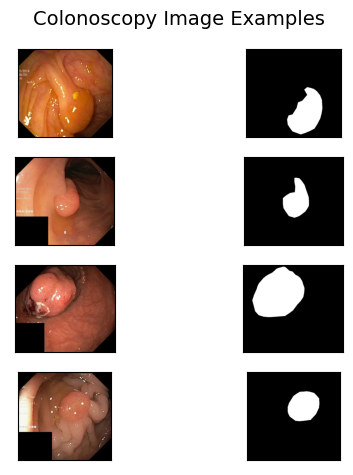

In [4]:
import random

rows = 4
cols = 2
fig, axs = plt.subplots(rows, cols)
fig.tight_layout()
axs = axs.ravel().tolist()

list_of_samples = random.choices(images_path, k=4)
masks_of_samples = list(map(lambda x: x.replace('images', 'masks'), list_of_samples))

for idx, num in enumerate(range(0, 8, 2)):
    img = cv2.imread(list_of_samples[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[num].imshow(img)

for idx, num in enumerate(range(1, 8, 2)):
    img = cv2.imread(masks_of_samples[idx])
    axs[num].imshow(img, cmap='gray')

fig.suptitle("Colonoscopy Image Examples", fontsize=14)
plt.setp(axs, xticks=[],yticks=[])
plt.tight_layout()

In [5]:
import deeplake
import os

os.environ['ACTIVELOOP_TOKEN'] = os.getenv('ACTIVELOOP_TOKEN')

c:\jason\new magang\DUCK-Net\.venv\lib\site-packages\deeplake\util\check_latest_version.py:32: UserWarning: A newer version of deeplake (3.8.17) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [6]:
ds_train = deeplake.empty('hub://jasonadrianzoom/colonoscopytrain')
ds_val = deeplake.empty('hub://jasonadrianzoom/colonoscopyval')
ds_test = deeplake.empty('hub://jasonadrianzoom/colonoscopytest')

Your Deep Lake dataset has been successfully created!


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/jasonadrianzoom/colonoscopytrain


hub://jasonadrianzoom/colonoscopytrain loaded successfully.
Your Deep Lake dataset has been successfully created!


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/jasonadrianzoom/colonoscopyval


hub://jasonadrianzoom/colonoscopyval loaded successfully.
Your Deep Lake dataset has been successfully created!


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/jasonadrianzoom/colonoscopytest


hub://jasonadrianzoom/colonoscopytest loaded successfully.


In [7]:
with ds_train:
    ds_train.create_tensor('images')
    ds_train.create_tensor('masks')

with ds_val:
    ds_val.create_tensor('images')
    ds_val.create_tensor('masks')

with ds_test:
    ds_test.create_tensor('images')
    ds_test.create_tensor('masks')

In [8]:
def load_data(img_height, img_width, images_to_be_loaded, dataset):
    IMAGES_PATH = os.path.join(folder_path, 'images')
    MASKS_PATH = os.path.join(folder_path, 'masks')

    if dataset == 'kvasir':
        train_ids = glob.glob(os.path.join(IMAGES_PATH, "*.jpg"))

    if dataset == 'cvc-clinicdb':
        train_ids = glob.glob(os.path.join(IMAGES_PATH , "*.tif"))

    if dataset == 'cvc-colondb' or dataset == 'etis-laribpolypdb':
        train_ids = glob.glob(os.path.join(IMAGES_PATH, "*.png"))

    if images_to_be_loaded == -1:
        images_to_be_loaded = len(train_ids)

    X_train = np.zeros((images_to_be_loaded, img_height, img_width, 3), dtype=np.uint8)
    Y_train = np.zeros((images_to_be_loaded, img_height, img_width), dtype=np.uint8)

    print('Resizing training images and masks: ' + str(images_to_be_loaded))
    for n, id_ in tqdm(enumerate(train_ids)):
        if n == images_to_be_loaded:
            break

        image_path = id_
        mask_path = image_path.replace("images", "masks")

        image = imread(image_path)
        mask_ = imread(mask_path)

        mask = np.zeros((img_height, img_width), dtype=np.bool_)

        pillow_image = Image.fromarray(image)

        pillow_image = pillow_image.resize((img_height, img_width))
        image = np.array(pillow_image)

        X_train[n] = image

        pillow_mask = Image.fromarray(mask_)
        pillow_mask = pillow_mask.resize((img_height, img_width), resample=Image.LANCZOS)
        mask_ = np.array(pillow_mask)
        mask_ = np.mean(mask_, axis=2)

        for i in range(img_height):
            for j in range(img_width):
                if mask_[i, j] >= 127:
                    mask[i, j] = 1

        Y_train[n] = mask

    Y_train = np.expand_dims(Y_train, axis=-1)

    return X_train, Y_train

In [9]:
# Loading the data

X, Y = load_data(img_size, img_size, -1, 'kvasir')

Resizing training images and masks: 1000


0it [00:00, ?it/s]C:\Users\jason\AppData\Local\Temp\ipykernel_2204\4153700849.py:41: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  pillow_mask = pillow_mask.resize((img_height, img_width), resample=Image.LANCZOS)
1000it [00:36, 27.58it/s]


In [10]:
# Splitting the data, seed for reproducibility

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle= True, random_state = seed_value)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.111, shuffle= True, random_state = seed_value)

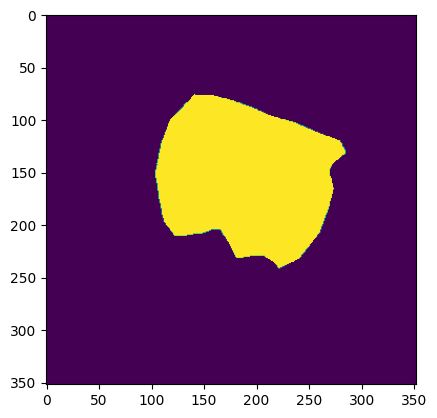

In [12]:
plt.imshow(y_train[0])

In [15]:
with ds_train:
    for i in range(x_train.shape[0]):
        image = x_train[i]
        mask = y_train[i]
        
        ds_train.append({'images': image, 'masks': mask})

In [13]:
with ds_val:
    for i in range(x_valid.shape[0]):
        image = x_valid[i]
        mask = y_valid[i]
        
        ds_val.append({'images': image, 'masks': mask})

In [14]:
with ds_test:
    for i in tqdm(range(x_test.shape[0])):
        image = x_test[i]
        mask = y_test[i]
        
        ds_test.append({'images': image, 'masks': mask})

100%|██████████| 100/100 [00:04<00:00, 23.85it/s]


In [16]:
ds_train = deeplake.load('hub://jasonadrianzoom/colonoscopytrain')

|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/jasonadrianzoom/colonoscopytrain



/

hub://jasonadrianzoom/colonoscopytrain loaded successfully.



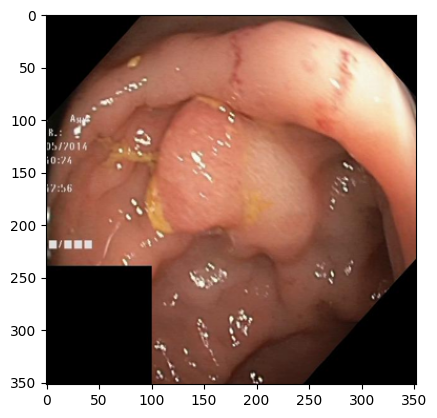

In [18]:
img = ds_train.images[0].numpy() 
mask_img = ds_train.masks[0].numpy()

plt.imshow(img)